## 29. 半教師ありGAN
**半教師あり学習**は、訓練データの一部にラベルが付与されている。  
ここで、ラベルが付与されているデータと付与されていないデータは同じ分布に従っていなければならない。  
**半教師ありGAN(SGAN: Semi-Supervised GAN)**は、識別器が多クラス分類器になっているGANであり、  
Nクラスの確率ベクトルと画像が本物か偽物かを示す確率を合わせてN+1クラスを識別するように学習する。  
  
SGANの生成器の目的はGANと同様であり、乱数ベクトルを入力にとり訓練データと見分けがつかない偽のサンプルを生成することである。  
識別器は、3つの入力を受け取るようになっている。  
- 生成器から出力される偽のサンプル($x^*$)
- 訓練データのうち、ラベルのないもの($x$)
- ラベルのあるもの($(x,y)$　yはラベル)

識別器の目標は、入力されるサンプルが本物の場合は正しくクラスに分類し、偽物の場合は偽物として却下することである。

#### 訓練プロセス
SGANの学習では、$D(x)$、$D(x^*)$に加え、教師ありのデータの損失$D((x,y))$の計算を行う。  
識別器は、
- 偽物のサンプルから本物のサンプルを区別すること(教師あり損失)
- 本物のサンプルを正しいクラスに分類すること(教師なし損失)

の2つの目的関数に対処(最小化)する。  
生成器は、損失$D(x^*)$の最大化することで、最大限間違うように訓練する。  
  
SGANは今までのGANと違い、最大の関心事は識別器にある。  
訓練が終わったら生成器は捨てられ、訓練済み識別器を分類器として利用する。

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dense, Dropout, Flatten, Input, Lambda, Reshape, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [10]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

In [58]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled
        
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
    
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5
            x = np.expand_dims(x, axis=3)
            return x
    
        def preprocess_labels(y):
            return y.reshape(-1, 1)
        
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
    
    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    
    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test

In [59]:
num_labeled = 100

dataset = Dataset(num_labeled)

#### 生成器

In [14]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    return model

#### 識別器

In [15]:
def build_discriminator_net(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes))
    
    return model

さらに2種類の出力を作り出す。  
- 教師あり部分

In [16]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model

- 教師なし部分

In [42]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    
    def predict(x):
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction
    
    model.add(Lambda(predict))
    return model

#### モデルの構築

In [49]:
def build_gan(generator ,discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

# 教師あり・教師なしの訓練中に共有
discriminator_net = build_discriminator_net(img_shape)

# 教師あり
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# 教師なし
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                 optimizer=Adam())

# 生成器
generator = build_generator(z_dim)

# 生成器の訓練中は識別器のパラメータは定数とする
discriminator_unsupervised.trainable = False

gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

#### 訓練
SGANの訓練アルゴリズム概要を以下に示す。  
  
For　各訓練ステップ　do
1. 識別器の訓練(教師あり)  
　a. ラベリングされた本物のデータ$(x,y)$からランダムにサンプルを取り出し、ミニバッチを作成する  
　b. ミニバッチから$D((x,y))$を計算し、求めた多クラスの分類損失を逆誤差伝播し、誤差を最小化するように$\theta^{(D)}$を更新する
2. 識別器の訓練(教師なし)  
　a. ラベルのない本物のデータ$x$からランダムにサンプルを取り出し、ミニバッチを作成する  
　b. ミニバッチから$D(x)$を計算し、求めた二値分類の損失を逆誤差伝播し、誤差を最小化するように$\theta^{(D)}$を更新する  
　c. ランダムなノイズベクトル$z$からなるミニバッチを作り、偽のサンプルからなるミニバッチを作る　$G(z)=x^*$  
　d. ミニバッチから$D(x^*)$を計算し、求めた二値分類の損失を逆誤差伝播し、誤差を最小化するように$\theta^{(G)}$を更新する  
3. 生成器の訓練  
　a. ラベルのない本物のデータ$z$からミニバッチを作り、偽のサンプルからなるミニバッチを作る　$G(z)=x^*$  
　b. ミニバッチから$D(x^*)$を計算し、求めた二値分類の損失を逆誤差伝播し、誤差を最小化するように$\theta^{(G)}$を更新する  

In [50]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # --------------------
        # 識別器の学習
        # --------------------
        imgs, labels = dataset.batch_labeled(batch_size)
        labels = to_categorical(labels, num_classes=num_classes)
        
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # ラベル付き本物サンプルによる訓練
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        
        # ラベルなし本物サンプルによる訓練
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        
        # 偽のサンプルによる訓練
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # --------------------
        # 生成器の学習
        # --------------------
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imags = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))
        
        if (iteration + 1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss supervised: %.4f, acc.: %.2f%%]" % (iteration + 1, d_loss_supervised, 100*accuracy))
            print("%d [D loss unsupervised: %.4f] [G loss: %f]" % (iteration + 1, d_loss_unsupervised, g_loss))

In [51]:
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0004, acc.: 100.00%]
800 [D loss unsupervised: 0.0002] [G loss: 0.021493]
1600 [D loss supervised: 0.0002, acc.: 100.00%]
1600 [D loss unsupervised: 0.0000] [G loss: 0.003939]
2400 [D loss supervised: 0.0000, acc.: 100.00%]
2400 [D loss unsupervised: 0.0000] [G loss: 0.001399]
3200 [D loss supervised: 0.0000, acc.: 100.00%]
3200 [D loss unsupervised: 0.0000] [G loss: 0.000317]
4000 [D loss supervised: 0.0000, acc.: 100.00%]
4000 [D loss unsupervised: 0.0000] [G loss: 0.000350]
4800 [D loss supervised: 0.0000, acc.: 100.00%]
4800 [D loss unsupervised: 0.0000] [G loss: 0.000041]
5600 [D loss supervised: 0.0000, acc.: 100.00%]
5600 [D loss unsupervised: 0.0000] [G loss: 0.000093]
6400 [D loss supervised: 0.0000, acc.: 100.00%]
6400 [D loss unsupervised: 0.0000] [G loss: 0.000008]
7200 [D loss supervised: 0.0000, acc.: 100.00%]
7200 [D loss unsupervised: 0.0000] [G loss: 0.000004]
8000 [D loss supervised: 0.0000, acc.: 100.00%]
8000 [D loss unsupervised: 0.0000] [

#### 精度の確認

In [52]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 3s 10ms/step - loss: 1.8342 - accuracy: 0.6830
Test Accuracy: 68.30%


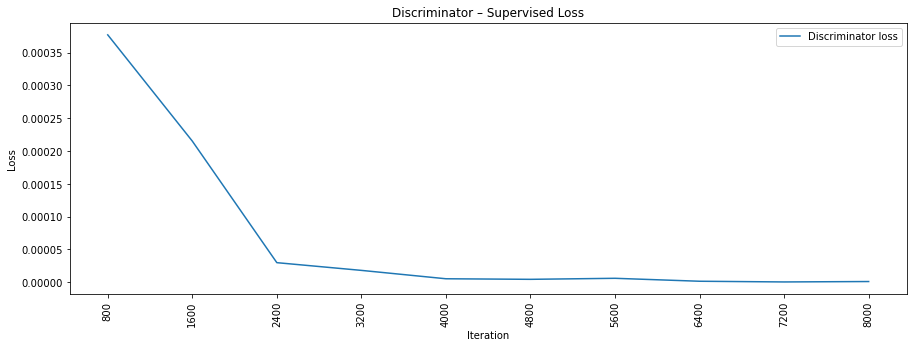

In [53]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [62]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [63]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 10ms/step - loss: 2.5203 - accuracy: 0.2500
Epoch 2/30
4/4 [==============================] - 0s 11ms/step - loss: 1.0406 - accuracy: 0.7100
Epoch 3/30
4/4 [==============================] - 0s 11ms/step - loss: 0.5805 - accuracy: 0.8400
Epoch 4/30
4/4 [==============================] - 0s 12ms/step - loss: 0.3827 - accuracy: 0.8900
Epoch 5/30
4/4 [==============================] - 0s 12ms/step - loss: 0.2165 - accuracy: 0.9700
Epoch 6/30
4/4 [==============================] - 0s 12ms/step - loss: 0.1502 - accuracy: 0.9800
Epoch 7/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0950 - accuracy: 0.9900
Epoch 8/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0953 - accuracy: 0.9900
Epoch 9/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0498 - accuracy: 0.9900
Epoch 10/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0386 - accuracy: 1.0000
Epoch 11/30
4/4 [============

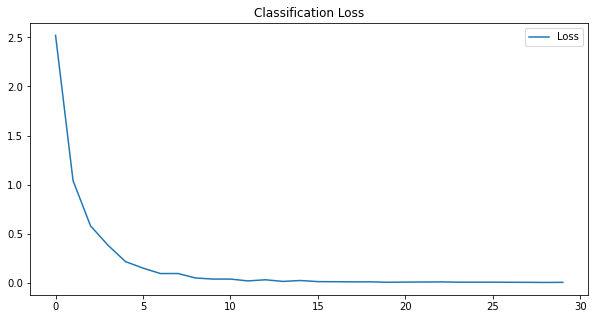

In [64]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

In [65]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 3s 9ms/step - loss: 1.9963 - accuracy: 0.3810
Test Accuracy: 38.10%
